<a href="https://colab.research.google.com/github/AmmaraYounas/Bone-Fracture-Detection-System/blob/main/Bone_Fracture_Detection_system_latest_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from PIL import Image, ImageOps

In [ ]:
generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.2
)

In [ ]:
Train_generator = generator.flow_from_directory(
    "/content/drive/MyDrive/archive (6)/train",
    target_size = (224, 224),
    batch_size = 16,
    class_mode ="categorical",
    subset = "training"
)

Validation_generator = generator.flow_from_directory(
    "/content/drive/MyDrive/archive (6)/val",
    target_size = (224, 224),
    batch_size = 16,
    class_mode ="categorical",
    subset = "validation"
)

Found 5136 images belonging to 4 classes.
Found 456 images belonging to 4 classes.


In [ ]:
Train_generator.next()[0].shape

(16, 224, 224, 3)

In [ ]:
Validation_generator.next()[0].shape

(16, 224, 224, 3)

In [ ]:
from tensorflow import keras


In [ ]:
base_model = keras.applications.Xception(
    weights=None,
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.trainable = True

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

x = base_model(inputs, training=True)
x = keras.layers.GaussianNoise(0.25)(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(512,activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.GaussianNoise(0.25)(x)
x = keras.layers.Dropout(0.25)(x)
outputs = keras.layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
from keras import callbacks

In [ ]:
earlyStopping = keras.callbacks.EarlyStopping(
    patience=7,
)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(Train_generator, epochs=1,
          callbacks=[earlyStopping,model_checkpoint_callback],
          validation_data=Validation_generator)

Epoch 1/3
  1/321 [..............................] - ETA: 1:06:09 - loss: 0.5833 - accuracy: 0.7500

KeyboardInterrupt: ignored

In [ ]:
model.save("Test Model 2.h5")

In [ ]:
model = load_model("/content/drive/MyDrive/Test Model 2.h5", compile=False)

In [ ]:
Test_Generator = generator.flow_from_directory(
    "/content/drive/MyDrive/archive (6)/val",
    target_size = (224, 224),
    batch_size = 16,
    class_mode ="categorical",
    subset = "training"
)

Found 1828 images belonging to 4 classes.


In [ ]:
model.evaluate(Test_Generator)

 18/115 [===>..........................] - ETA: 9:46 - loss: 0.5789 - accuracy: 0.7500

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


115/115 [==============================] - 703s 6s/step - loss: 0.5792 - accuracy: 0.7500


[0.5792310237884521, 0.75]

MessageError: ignored

In [ ]:
def diagnosis(img):
  np.set_printoptions(suppress=True)

  model = load_model("/content/drive/MyDrive/Test Model 2.h5", compile=False)

  class_names = open("/content/drive/MyDrive/labels.txt", "r").readlines()

  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

  image = Image.open(img).convert("RGB")

  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

  image_array = np.asarray(image)

  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

  data[0] = normalized_image_array


  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[int(index)]


  return class_name



In [ ]:
def dis_measure(gray):

  contours,_ = cv.findContours(gray, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  rotated_rect = cv.minAreaRect(contours[0])
  rotation_angle = rotated_rect[-1]

  return rotation_angle

In [ ]:
def crack_count(img,gray):

  blank =np.zeros(img.shape,dtype='uint8')

  blur=cv.GaussianBlur(gray,(17,17),0)
  canny=cv.Canny(blur,30,150,3)

  dilated=cv.dilate(canny,(17,17),iterations=1)

  contour,_=cv.findContours(dilated,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(blank,contour,-1,(0,0,255),2)

  gray=cv.cvtColor(blank,cv.COLOR_BGR2GRAY)
  blur=cv.GaussianBlur(gray,(17,17),0)
  canny=cv.Canny(blur,100,100)

  contour,_=cv.findContours(canny,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_TC89_L1)
 #blank=rescaleFrame(blank,scale=0.3)
  #cv2_imshow(blank)

  return len(contour)



In [ ]:
def rescaleFrame(img,scale=0.5):
  width=int(img.shape[1]*scale)
  height=int(img.shape[0]*scale)

  dimensions=(width,height)#tuple
  interpolation=cv.INTER_AREA

  return cv.resize(img,(width,height),interpolation)

# Bounding Box


In [ ]:
def bounding_box(img,gray):

  edges = cv.Canny(gray, 50, 150)
  contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  contours = sorted(contours, key=cv.contourArea, reverse=True)

  contour_image = img.copy()
  cv.drawContours(contour_image, contours, 0, (0, 255, 0), 2)

  if len(contours) > 0:
      largest_contour = contours[0]

      x, y, w, h = cv.boundingRect(largest_contour)

      cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

  else:
      print("No Detection found.")

  return img

# Measuring object

In [ ]:
def dimensions(image,gray):
  img = cv.imread('/content/drive/MyDrive/archive (6)/train/Major Bone Fracture/0_wny3n8ot.jpg')

  known_width= 8.04
  known_height= 12.89

  gray_ref = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

  _,thresh_ref= cv.threshold(gray_ref, 128, 255, cv.THRESH_BINARY)
  contours_ref, _ = cv.findContours(thresh_ref, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)


  ref_contour = contours_ref[0]
  x, y, w, h = cv.boundingRect(ref_contour)
  ref_width_pixels = w
  ref_height_pixels = h

  pixels_per_cm_width = ref_width_pixels / known_width
  pixels_per_cm_height = ref_height_pixels / known_height


  _,thresh= cv.threshold(gray, 128, 255, cv.THRESH_BINARY)
  contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Assuming there's only one contour (the reference object)

  target_contour = contours[0]

  x, y, w, h = cv.boundingRect(target_contour)

  object_width_pixels = w
  object_height_pixels = h

  object_width_cm = round(object_width_pixels / pixels_per_cm_width,2)
  object_height_cm =round(object_height_pixels / pixels_per_cm_height,2)

  return object_height_cm,object_width_cm,


In [ ]:
def show_results(img):

  diag=diagnosis(img)
  img=cv.imread(img)
  gray= cv.cvtColor(img, cv.COLOR_BGR2GRAY)

  cv2_imshow(rescaleFrame(bounding_box(img,gray)))
  height,width=dimensions(img,gray)

  print(f"Diagnosis: {diag}")
  print(f"Bone Height: {height} cm and Width : {width} cm.\n")
  print(f"Crack Count: {crack_count(img,gray)}\n")
  print(f"Dislocation Measurement: {dis_measure(gray)}\n")

  cv.waitKey(0)
  if diag=='Major Fracture':
    cv.imwrite('/content/drive/MyDrive/archive (6)/train/Major Bone Fracture/Major Fracture',img)
  elif diag=='Minor Fracture':
    cv.imwrite('/content/drive/MyDrive/archive (6)/train/minor Bone Fracture/Minor Fracture',img)
  elif diag=='Dislocation':
    cv.imwrite('/content/drive/MyDrive/archive (6)/train/Dislocation/Dislocated Bone',img)
  elif diag=='Not Fracture':
    cv.imwrite('/content/drive/MyDrive/archive (6)/train/not fractured/not fructured bone',img)


1/1 [==============================] - 1s 1s/step


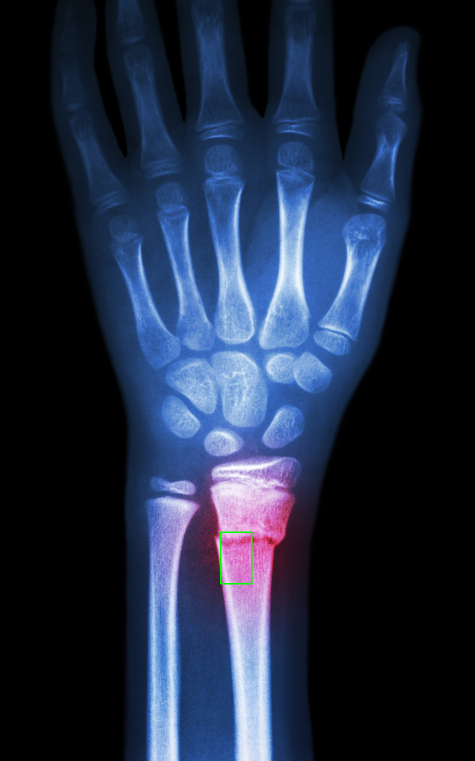

Diagnosis: Major Fracture

Bone Height: 12.89 cm and Width : 8.04 cm.

Crack Count: 0

Dislocation Measurement: -90.0



In [ ]:
show_results("/content/drive/MyDrive/archive (6)/train/Major Bone Fracture/0_wny3n8ot.jpg")